Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# ResNet on CIFAR with Flax and JAXopt.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/resnet_flax.ipynb)

In this notebook, we'll go through training a deep residual network with jaxopt.

In [1]:
%%capture
%pip install -U jaxopt flax tqdm

In [2]:
from functools import partial
from typing import Any, Callable, Sequence, Tuple, Optional, Sequence, Dict

from flax import linen as nn

import jax
import jax.numpy as jnp
from tqdm.notebook import trange
import numpy as np

import optax
import tensorflow_datasets as tfds
import tensorflow as tf

from matplotlib import pyplot as plt

import jaxopt
from jaxopt import OptaxSolver

# hide the GPU from tensorflow, otherwise it might
# reserve memory on it
tf.config.experimental.set_visible_devices([], "GPU")

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [3]:
# @markdown Total number of epochs to train for:
MAX_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown The initial learning rate for the optimizer:
PEAK_LR = 0.12  # @param{type:"number"}
# @markdown The model architecture for the neural network. Can be one of `'resnet1'`, `'resnet18'`, `'resnet34'`, `'resnet50'`, `'resnet101'`, `'resnet152'` and `'resnet200'`:
MODEL = "resnet18"  # @param{type:"string"}
# @markdown The dataset to use. Could be either `'cifar10'` or `'cifar100'`:
DATASET = "cifar10"  # @param{type:"string"}
# @markdown The amount of L2 regularization (aka weight decay) to use:
L2_REG = 1e-4  # @param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDUAALH/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDUAALH/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


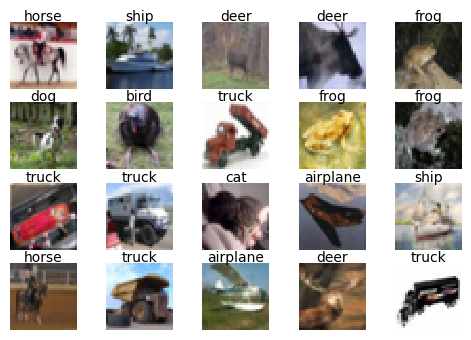

In [4]:
(train_loader, test_loader), info = tfds.load(
    DATASET, split=["train", "test"], as_supervised=True, with_info=True
)
NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape


def plot_sample_images(loader):
  loader_iter = iter(loader)
  _, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
  for i in range(4):
    for j in range(5):
      k = i * 4 + j
      image, label = next(loader_iter)
      axes[i, j].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      axes[i, j].set_axis_off()
      axes[i, j].set_title(info.features["label"].names[label], fontsize=10, y=0.9)


plot_sample_images(train_loader)

The accuracy of the model can be improved significantly through data augmentation. That is, instead of training on the above images, we'll generate random modifications of the images and train on those. This is done by using the `transform` argument of `tfds.load` to apply a random crop, random horizontal flip, and random color jittering.

In the next cell we show an instance of these transformations on the above images.

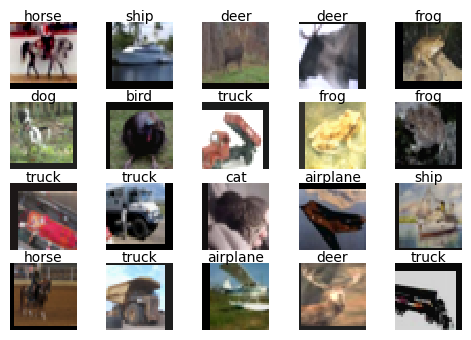

In [5]:
def augment(image, label):
  """Data augmentation for CIFAR10."""
  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  return image, label


train_loader_augmented = train_loader.map(augment)
plot_sample_images(train_loader_augmented)

We now shuffle the data in the train set and create batches of size `'BATCH_SIZE'` for both train and test set

In [6]:
train_loader_batched = train_loader_augmented.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

With the data ready, we can now define the model. Below we define the ResNet architecture that we'll later instantiate. We define different variants of the architecture with different sizes and depths (`'ResNet1'`, `'ResNet18'`, `'ResNet34'`, `'ResNet50'` and `'ResNet101'`).

The following code is based on the [Flax imagenet example](https://github.com/google/flax/blob/main/examples/imagenet/models.py). The only difference with that code is the addition of the keyword argument `initial_conv_config` to the `ResNet` class, which allows to change the configuration of the initial convolutional layer of the network. This is important to get state of the art accuracy on CIFAR10, as the default kernel size (7, 7) is too big for the small 32x32 images of CIFAR10.

In [7]:
ModuleDef = Any


class ResNetBlock(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1), self.strides, name="conv_proj")(
          residual
      )
      residual = self.norm(name="norm_proj")(residual)

    return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters * 4, (1, 1), self.strides, name="conv_proj")(
          residual
      )
      residual = self.norm(name="norm_proj")(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1."""

  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv
  initial_conv_config: Optional[Dict[str, Any]] = None

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(
        nn.BatchNorm,
        use_running_average=not train,
        momentum=0.9,
        epsilon=1e-5,
        dtype=self.dtype,
    )

    initial_conv_config = dict(self.initial_conv_config)
    initial_conv_config.setdefault("kernel_size", 7)
    initial_conv_config.setdefault("stride", 2)
    initial_conv_config.setdefault("with_bias", False)
    initial_conv_config.setdefault("padding", "SAME")
    initial_conv_config.setdefault("name", "initial_conv")

    x = conv(self.num_filters, **self.initial_conv_config)(x)
    x = norm(name="bn_init")(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding="SAME")
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=strides,
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet1 = partial(ResNet, stage_sizes=[1], block_cls=ResNetBlock)
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)
ResNet50 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=BottleneckResNetBlock)
ResNet101 = partial(ResNet, stage_sizes=[3, 4, 23, 3], block_cls=BottleneckResNetBlock)
ResNet152 = partial(ResNet, stage_sizes=[3, 8, 36, 3], block_cls=BottleneckResNetBlock)
ResNet200 = partial(ResNet, stage_sizes=[3, 24, 36, 3], block_cls=BottleneckResNetBlock)

As mentioned before, the default kernel size of (7, 7) in the first convolutional layer is too big for the small image sizes of CIFAR10. Because of this, we will instantiate the network with a custom kernel size of (3, 3) and strides of 1. Note that this is specific to CIFAR10, and datasets with bigger images such as ImageNet or CelebA should instead use the default values.

In [8]:
initial_conv_config = {
    "kernel_size": (3, 3),
    "strides": 1,
    "padding": "SAME",
}
# Set up model.
if MODEL == "resnet1":
  net = ResNet1(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet18":
  net = ResNet18(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet34":
  net = ResNet34(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet50":
  net = ResNet50(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet101":
  net = ResNet101(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet152":
  net = ResNet152(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
elif MODEL == "resnet200":
  net = ResNet200(num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)
else:
  raise ValueError(f"Unknown model {MODEL}.")

We'll now load our train and test dataset and plot a few of the training images.

In [37]:
def _predict(params, bn_params, inputs, train=False):
  # Predict logits from inputs and parameters
  all_params = {"params": params, "batch_stats": bn_params}

  def train_fn(inputs):
    logits, net_state = net.apply(
        all_params, inputs, train=True, mutable=["batch_stats"]
    )
    return logits, net_state

  def eval_fn(inputs):
    logits = net.apply(all_params, inputs, train=False, mutable=False)
    net_state = {"batch_stats": bn_params}
    return logits, net_state

  logits, net_state = jax.lax.cond(
      train, lambda x: train_fn(x), lambda x: eval_fn(x), inputs
  )
  return logits, net_state


logistic_loss = jax.vmap(jaxopt.loss.multiclass_logistic_loss)


@jax.jit
def loss_accuracy(params, bn_params, data, train=True):
  """Compute loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    bn_params: batch normalization parameters.
    data: tuple of (inputs, labels).
    train: whether to use train mode or eval mode.
  """
  inputs, labels = data
  logits, net_state = _predict(params, bn_params, inputs, train=train)
  mean_loss = jnp.mean(logistic_loss(labels, logits))
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  l2_params = jax.tree_util.tree_leaves(params)
  # make sure batchnorm parameters and biases are not regularized
  weight_l2 = sum(jnp.sum(x**2) for x in l2_params if x.ndim > 1)
  loss = mean_loss + 0.5 * L2_REG * weight_l2
  return loss, {"accuracy": accuracy, "batch_stats": net_state["batch_stats"]}

We'll use a learning rate that initially increases up to the peak value of `'PEAK_LR'` and then decreases. Such learning rate is implemented (for instance) in optax's [linear_onecycle_schedule](https://optax.readthedocs.io/en/latest/api.html#optax.linear_onecycle_schedule).

Below we create the learning rate and plot its value across iterations.

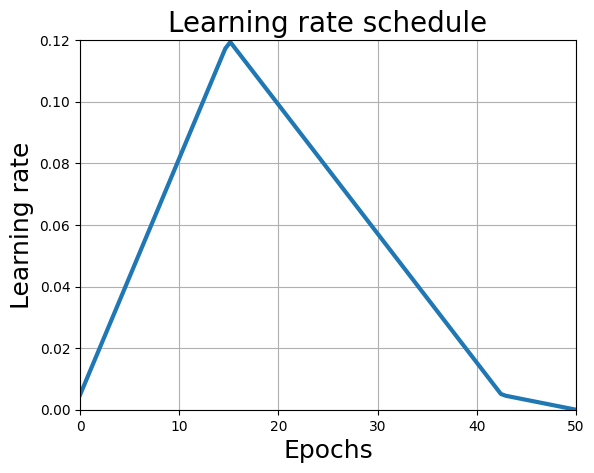

In [10]:
iter_per_epoch_train = info.splits["train"].num_examples // BATCH_SIZE
lr_schedule = optax.linear_onecycle_schedule(MAX_EPOCHS * iter_per_epoch_train, PEAK_LR)

# plot the learning rate schedule
iterate_subsample = np.linspace(0, MAX_EPOCHS * iter_per_epoch_train, 100)
plt.title("Learning rate schedule", fontsize=20)
plt.plot(
    np.linspace(0, MAX_EPOCHS, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Learning rate", fontsize=18)
plt.grid()
plt.xlim((0, MAX_EPOCHS))
plt.ylim((0, PEAK_LR))
plt.show()

In the next two cells we'll initialize the variables and states. We also define a convenience function `dataset_stats` that we'll call once per epoch to collect the loss and accuracy of our solver over the test set.

In [11]:
opt = optax.sgd(lr_schedule, momentum=0.9, nesterov=False)

# We need has_aux=True because loss_fun returns batch_stats.
solver = OptaxSolver(
    opt=opt, fun=loss_accuracy, maxiter=MAX_EPOCHS * len(train_loader), has_aux=True
)

# Initialize parameters.
rng = jax.random.PRNGKey(0)
# Dummy data to initialize parameters and solver state.
dummy_data = jnp.ones((1,) + IMG_SIZE, jnp.float32)
dummy_targets = jnp.ones(1, int)
variables = net.init({"params": rng}, dummy_data)

var_params, var_batch_stats = variables["params"], variables["batch_stats"]

In [12]:
# Define parameter update function.
solver_state = solver.init_state(
    var_params, var_batch_stats, (dummy_data, dummy_targets)
)


def dataset_stats(params, var_batch_stats, data_loader):
  """Compute loss and accuracy over the dataset `data_loader` for `max_iter` items."""
  all_accuracy = []
  all_loss = []
  for batch in data_loader.as_numpy_iterator():
    loss, aux = loss_accuracy(params, var_batch_stats, batch, train=False)
    all_accuracy.append(aux["accuracy"])
    all_loss.append(loss)
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Finally, we do the actual training. The next cell performs `'MAX_EPOCHS'` epochs of training. Within each epoch we iterate over the batched loader `train_loader_batched`, and once per epoch we also compute the test set accuracy and loss.

In [13]:
train_accuracy = []
train_loss = []
# Compute test set accuracy at initialization
test_stats = dataset_stats(var_params, var_batch_stats, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_loss = [test_stats["loss"]]

# Training loop.
pbar = trange(MAX_EPOCHS, desc="Training progress", leave=True, unit="epochs")
for epoch in pbar:
  train_accuracy_epoch = []
  train_loss_epoch = []

  for batch in train_loader_batched.as_numpy_iterator():
    var_params, solver_state = solver.update(
        params=var_params,
        state=solver_state,
        bn_params=var_batch_stats,
        data=batch,
    )
    var_batch_stats = solver_state.aux["batch_stats"]
    train_accuracy_epoch.append(solver_state.aux["accuracy"])
    train_loss_epoch.append(solver_state.value)

  # once per epoch, make a pass over the test set to compute accuracy
  test_stats = dataset_stats(var_params, var_batch_stats, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_loss.append(test_stats["loss"])
  train_accuracy.append(np.mean(train_accuracy_epoch))
  train_loss.append(np.mean(train_loss_epoch))

  # update progress bar
  pbar.set_postfix({
      "test set accuracy": test_accuracy[-1],
      "train set accuracy": np.mean(train_accuracy_epoch),
  })

Training progress:   0%|          | 0/50 [00:00<?, ?epochs/s]

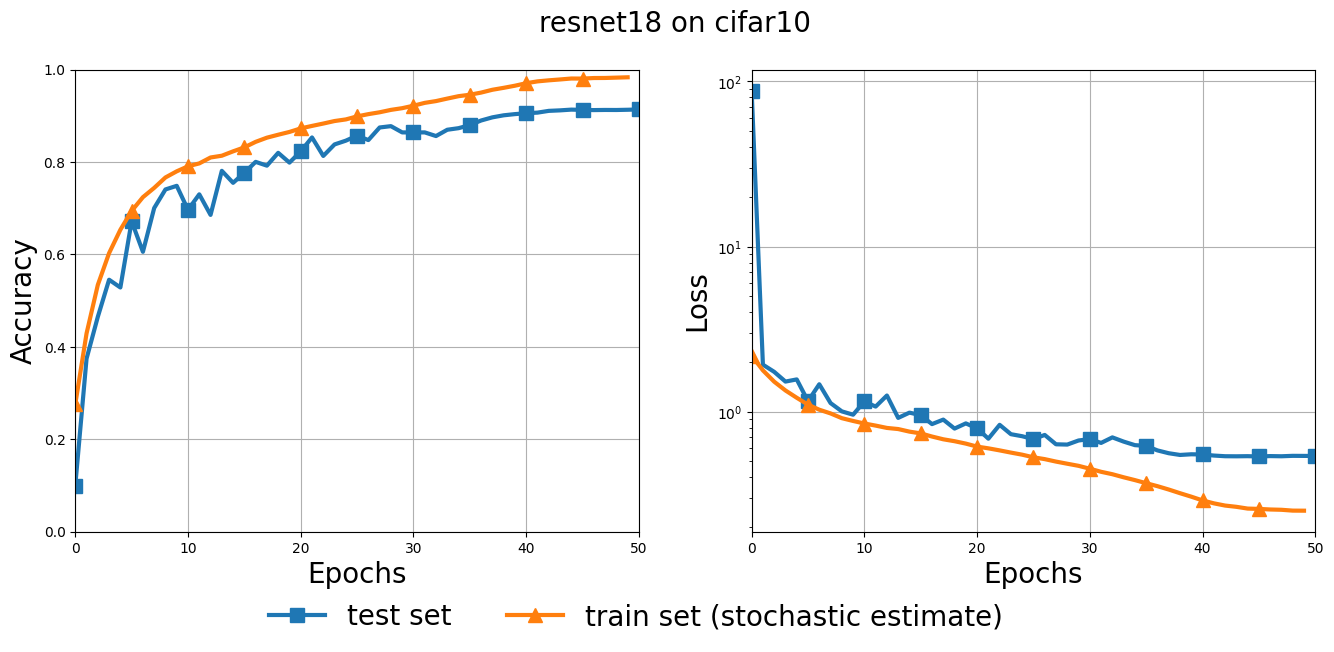

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle(f"{MODEL} on {DATASET}", fontsize=20)

ax1.plot(test_accuracy, lw=3, marker="s", markevery=5, markersize=10, label="test set")
ax1.plot(
    train_accuracy,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.grid()
ax1.set_xlabel("Epochs", fontsize=20)
ax1.set_xlim((0, MAX_EPOCHS))
ax1.set_ylim((0, 1))

ax2.plot(test_loss, lw=3, marker="s", markevery=5, markersize=10, label="test set")
ax2.plot(
    train_loss,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax2.set_ylabel("Loss", fontsize=20)
ax2.grid()
ax2.set_xlabel("Epochs", fontsize=20)
ax2.set_xlim((0, MAX_EPOCHS))

# set legend at the bottom of the plot
ax1.legend(frameon=False, fontsize=20, ncol=2, loc=2, bbox_to_anchor=(0.3, -0.1))

ax2.set_yscale("log")

plt.show()

In [15]:
print("Final test set accuracy:", test_accuracy[-1])

Final test set accuracy: 0.91396236
